In [13]:
import torch
import torch.nn as nn
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchinfo import summary
from datetime import datetime

if torch.cuda.is_available():
    print("Using GPU")
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    print("Using MPS")
    device = torch.device("mps")
else:
    print("Using CPU")
    device = torch.device("cpu")


Using MPS


In [2]:
def directional_accuracy(gt, pred):
    """Calculates directional accuracy of given ground truth and prediction series.
    From Kaeley et al.
    
    inputs:
        gt: ground truth prices
        pred: predicted prices
        
    returns:
        acc: directional accuracy of predicted values
    """
    acc = []
    for i in range(1, len(gt)):
        if gt[i] >= gt[i-1] and pred[i] >= gt[i-1]:
            acc.append(1)
        elif gt[i] < gt[i-1] and pred[i] < gt[i-1]:
            acc.append(1)
        else:
            acc.append(0)

    return np.array(acc).mean()


def z_norm(df, col_exclude=None):
    """Performs z-score normalization on all columns of df except col_exclude
    
    inputs:
        df: stock data
        col_exclude: columns to be excluded from normalization
        
    returns:
        df_std: normalized z-score data
        stat_dict: dict where keys are each normalized column name,
                   values are tuple of (mean, std)
    """

    stat_dict = dict()
    df_std = df.copy()
    cols = list(df.columns)
    cols.remove(col_exclude)
    for c in cols:
        stat_dict[c] = (df[c].mean(), df[c].std()) #
        df_std[c] = (df[c] - df[c].mean()) / df[c].std()

    return df_std, stat_dict


def reverse_z_norm(df, stat_dict, col_exclude=None):
    """Reverses z-score normalization on all columns except col_exclude
    
    inputs:
        df: normalized stock data
        stat_dict: dict returned by z_norm
        col_exclude: columns to be excluded
        
    returns:
        df_real: dataframe of unnormalized columns
    """

    df_real = df.copy()
    cols = list(df.columns)
    [cols.remove(c) for c in col_exclude]
    for c in cols:
        mean, std = stat_dict[c]
        df_real[c] = df[c] * std + mean # reverse z score calculation to restore original data

    return df_real


def to_sequences(seq_size: int, obs: np.array):
    """Splits a table of data into sequences of given length"""

    x = []
    y = []
    for i in range(len(obs) - seq_size):
        window = obs[i:(i + seq_size), :]
        after_window = obs[i + seq_size, :]
        x.append(window)
        y.append(after_window)
    return x, y

def process_results(model_out: torch.Tensor, batch_size: int, 
                    batch_num: int, dates: list, tickers: list):
    """Function to process output tensor from network into usable data.
    Each batch output needs to be put in the correct list for its company

    inputs:
        model_out: tensor of size (batch_size, num_features)
        batch_size: batch size of dataloader
        batch_num: which batch is the loop on
        dates: list of dates that line up with the rows of the output data
        tickers: list of ticker symbols

    returns:
        processed: list of arrays
    """

    processed = []

    for idx, batch_out in enumerate(model_out):
        date_idx = batch_num * batch_size + idx
        date = dates[date_idx] # find date of predicted day
        
        pred_list = batch_out.detach().tolist()
        # ticker is last column since date was dropped
        # change from model output ticker to character ticker
        pred_list.append(tickers[idx])
        pred_list.append(date) # add prediction date to list
        processed.append(pred_list) # add to overall 2d array
        
    return processed

def directional_accuracy(gt, pred):
    """Calculates directional accuracy of given ground truth and prediction series.
    From Kaeley et al. https://arxiv.org/pdf/2305.14368.pdf
    
    inputs:
        gt: ground truth prices
        pred: predicted prices
        
    returns:
        acc: directional accuracy of predicted values
    """
    acc = []
    for i in range(1, len(gt)):
        if gt[i] >= gt[i-1] and pred[i] >= gt[i-1]:
            acc.append(1)
        elif gt[i] < gt[i-1] and pred[i] < gt[i-1]:
            acc.append(1)
        else:
            acc.append(0)

    return np.array(acc).mean()

# Hyperparameters

In [ ]:
seq_size = 30 # number of previous days used to predict next day
test_start_date = pd.to_datetime("2022-03-01")
out_cols = ['open', 'close', 'high', 'low', 'pct_change']
epochs = 500

In [3]:
# loading data
data_path = 'data'
interval = '1d'
# companies = os.listdir(data_path)
companies = ['AAPL']
for c in companies:
    if c == 'constituents.csv':
        companies.remove(c)
    elif c == '.DS_Store':
        companies.remove('.DS_Store')

# make unique number for each company ticker
ids = np.linspace(0, 1, len(companies)).round(5)
company_stats = dict() # keys are ticker, values are that company's stat dict
num_to_ticker = dict()
ticker_to_num = dict()
for i, num in enumerate(ids):
    num_to_ticker[num] = companies[i]
    ticker_to_num[companies[i]] = num

df_list = []
stats_list = []
x_train = []
x_test = []
y_train = []
y_test = []
dates = []

for co in companies:
    files = os.listdir(os.path.join(data_path, co))
    for f in files: # check each company folder for specific interval of data
        if interval in f:
            file = f

    df = pd.read_csv(os.path.join(data_path, co, file))
    df['date'] = pd.to_datetime(df['date'])
    df = df.drop(columns=['Unnamed: 0'])

    # normalize columns, excluding date column
    df_normed, stat_dict = z_norm(df, 'date')
    # add ticker column
    df_normed['ticker'] = ticker_to_num[co]

    cols = list(df_normed.columns)
    cols.append(cols.pop(cols.index('date'))) # move date to end of list since this will be the order of columns for output df

    # split each df into train and test timeframes
    df_train = df_normed[df_normed['date'] < test_start_date]
    df_test = df_normed[df_normed['date'] >= test_start_date]

    pred_dates = df_test['date'].iloc[seq_size:].tolist()
    dates.append(pred_dates)

    # make copy of test df for use in testing
    # df_cpy = df_test.copy()

    # drop unnecessary columns
    df_train = df_train.drop(columns=['date'])
    df_test = df_test.drop(columns=['date'])

    # store column indices for extracting output features we want
    feature_cols_idx = [list(df_train.columns).index(feature) for feature in out_cols]

    # convert to 2D numpy arrays of shape (-1, num_cols)
    train = df_train.to_numpy()
    test = df_test.to_numpy()

    # convert to sequences and append to respective training and testing lists
    x, y = to_sequences(seq_size, train)
    for i in range(len(x)):
        x_train.append(x[i])
        y_train.append(y[i])
    x, y = to_sequences(seq_size, test)
    for i in range(len(x)):
        x_test.append(x[i])
        y_test.append(y[i])

    company_stats[co] = stat_dict
    stats_list.append(stat_dict)

indims = y_train[0].shape[0]
outdims = 5 # open, close, high, low, pct_change
batch_size = 32
dates = [element for nestedlist in dates for element in nestedlist]

x_train = np.vstack(x_train).reshape(-1, seq_size, indims)
y_train = np.vstack(y_train).reshape(-1, indims)
x_test = np.vstack(x_test).reshape(-1, seq_size, indims)
y_test = np.vstack(y_test).reshape(-1, indims)

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Using basic transformer from https://github.com/jeffheaton/app_deep_learning/blob/main/t81_558_class_10_3_transformer_timeseries.ipynb

In [4]:
# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
    
# Model definition using Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, d_model=64, nhead=4, num_layers=2, dropout=0.1):
        super(TransformerModel, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, output_dim)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x[:, -1, :])
        return x

model = TransformerModel(input_dim=indims, output_dim=outdims).to(device)

In [5]:
# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=10, verbose=True)

early_stop_count = 0
min_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    train_losses = []
    for batch in train_loader:
        x_batch, y_batch = batch
        y_batch = y_batch[:, feature_cols_idx]
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        train_losses.append(loss.item())
        optimizer.step()

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            y_batch = y_batch[:, feature_cols_idx]
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    train_loss = np.mean(train_losses)
    scheduler.step(val_loss)

    # uncomment for early stopping
    # if val_loss < min_val_loss:
    #     min_val_loss = val_loss
    #     early_stop_count = 0
    # else:
    #     early_stop_count += 1

    # if early_stop_count >= 5:
    #     print("Early stopping!")
    #     break
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

Epoch 1/1000, Train Loss: 0.2768, Validation Loss: 0.2955
Epoch 2/1000, Train Loss: 0.2160, Validation Loss: 0.2441
Epoch 3/1000, Train Loss: 0.2178, Validation Loss: 0.2405
Epoch 4/1000, Train Loss: 0.2077, Validation Loss: 0.2268
Epoch 5/1000, Train Loss: 0.2105, Validation Loss: 0.2257
Epoch 6/1000, Train Loss: 0.2072, Validation Loss: 0.2181
Epoch 7/1000, Train Loss: 0.2059, Validation Loss: 0.2386
Epoch 8/1000, Train Loss: 0.2028, Validation Loss: 0.2443
Epoch 9/1000, Train Loss: 0.2022, Validation Loss: 0.2272
Epoch 10/1000, Train Loss: 0.2039, Validation Loss: 0.2157
Epoch 11/1000, Train Loss: 0.2020, Validation Loss: 0.2137
Epoch 12/1000, Train Loss: 0.2040, Validation Loss: 0.2535
Epoch 13/1000, Train Loss: 0.2003, Validation Loss: 0.2329
Epoch 14/1000, Train Loss: 0.1971, Validation Loss: 0.2287
Epoch 15/1000, Train Loss: 0.2000, Validation Loss: 0.2771
Epoch 16/1000, Train Loss: 0.2014, Validation Loss: 0.2398
Epoch 17/1000, Train Loss: 0.1887, Validation Loss: 0.2357
Epoch 

KeyboardInterrupt: 

In [7]:
saved_weights_path = 'saved_models'
fn = f'AAPL_model_{datetime.now().strftime("%Y%m%d")}.pt'

In [8]:
torch.save(model.state_dict(), os.path.join(saved_weights_path, fn))

# Testing

In [9]:
def process_results(model_out: torch.Tensor, batch_size: int, 
                    batch_num: int, dates: list, tickers: list):
    """Function to process output tensor from network into usable data.
    Each batch output needs to be put in the correct list for its company

    inputs:
        model_out: tensor of size (batch_size, num_features)
        batch_size: batch size of dataloader
        batch_num: which batch is the loop on
        dates: list of dates that line up with the rows of the output data
        tickers: list of ticker symbols

    returns:
        processed: list of arrays
    """

    processed = []

    for idx, batch_out in enumerate(model_out):
        date_idx = batch_num * batch_size + idx
        date = dates[date_idx] # find date of predicted day
        
        pred_list = batch_out.detach().tolist()
        # ticker is last column since date was dropped
        # change from model output ticker to character ticker
        pred_list.append(tickers[idx])
        pred_list.append(date) # add prediction date to list
        processed.append(pred_list) # add to overall 2d array
        
    return processed

# testing with metrics
# model = TransformerModel(input_dim=indims, output_dim=outdims).to(device)
# model.load_state_dict(torch.load(os.path.join(saved_weights_path, "AAPL_model_20240209.pt")))
results = []
gt_preds = []
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        x_batch, y_batch = batch
        tickers = [num_to_ticker[y_batch.detach().numpy()[idx,-1]] for idx in range(y_batch.shape[0])]
        y_batch = y_batch[:, feature_cols_idx]
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)

        gt_outputs = process_results(y_batch, batch_size, i, dates, tickers)
        processed_outputs = process_results(outputs, batch_size, i, dates, tickers)

        [results.append(out) for out in processed_outputs]
        [gt_preds.append(out) for out in gt_outputs]

columns = [ele for nested in [out_cols, ['ticker', 'date']] for ele in nested]
df_pred = pd.DataFrame(results, columns=columns)
df_gt = pd.DataFrame(gt_preds, columns=columns)
for co in companies:
    df_pred[df_pred['ticker'] == co] = reverse_z_norm(df_pred, company_stats[co], col_exclude=['ticker', 'date'])
    df_gt[df_pred['ticker'] == co] = reverse_z_norm(df_gt, company_stats[co], col_exclude=['ticker', 'date'])

In [10]:
df_pred.head()

,open,close,high,low,pct_change,ticker,date
0,158.967484,158.157973,160.279960,156.998852,-0.004663,AAPL,2022-04-12
1,160.579900,159.285250,162.490462,158.709311,-0.000413,AAPL,2022-04-13
2,170.025862,170.780097,176.788700,170.999861,-0.002143,AAPL,2022-04-14
3,168.303912,169.560318,170.957456,167.602318,-0.000566,AAPL,2022-04-18
4,160.939702,165.231304,162.135592,159.423636,-0.000562,AAPL,2022-04-19


In [ ]:
df_gt.head()

,open,close,high,low,pct_change,ticker,date
0,164.490003,163.170002,165.549997,162.100003,-0.018408,AAPL,2022-03-04
1,163.360000,159.300003,165.020001,159.040000,-0.023718,AAPL,2022-03-07
2,158.819997,157.439998,162.879998,155.800003,-0.011676,AAPL,2022-03-08
3,161.479999,162.949997,163.410001,159.409999,0.034997,AAPL,2022-03-09
4,160.199997,158.520003,160.390002,155.980002,-0.027186,AAPL,2022-03-10


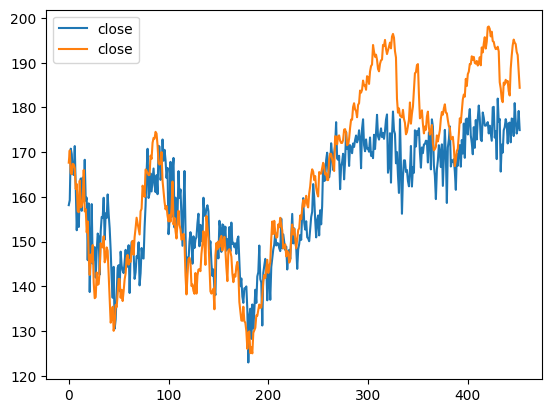

In [22]:
df_pred[df_pred['ticker'] == 'AAPL']['close'].plot()
df_gt[df_gt['ticker'] == 'AAPL']['close'].plot()
plt.legend()
plt.show()

In [19]:
directional_accuracy(df_gt['open'], df_pred['open'])

0.5265486725663717

In [20]:
directional_accuracy(df_gt['close'], df_pred['high'])

0.4889380530973451